# Hand Gesture Recognition

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#CNN">CNN modle</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> This dataset collects 

> Description of all features and the data itself is [here]()

In [277]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers.experimental.preprocessing as AugLayers
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [278]:
df_train = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
df_validation = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [279]:
# import os
# current_directory = os.getcwd()

# df_train = pd.read_csv(current_directory + '\DataSource' + '\sign_mnist_train.csv')
# df_validation = pd.read_csv(current_directory + '\DataSource' + '\sign_mnist_test.csv')
# df_train.head(2)

In [280]:
print(f'Shape of Train dataSet is: {df_train.shape}')
print(f'Shape of Validation dataSet is: {df_validation.shape}')

Shape of Train dataSet is: (27455, 785)
Shape of Validation dataSet is: (7172, 785)


<a id='eda'></a>
## Exploratory Data Analysis

### Making reialable labels, Comes form the original dataSet

In [281]:
import string
Alphabet_labels = list(string.ascii_letters)

### Converting images into shape of w x h

In [282]:
# Frist for train images
imgWidth = int(np.sqrt(len(df_train.columns) - 1))


X_train = df_train.loc[:, 'pixel1':] / 255
print(f'Shape befor resizing: {X_train.shape}')
X_train = X_train.values.reshape(-1, imgWidth, imgWidth)
print(f'Shape after resizing: {X_train.shape}')

Shape befor resizing: (27455, 784)
Shape after resizing: (27455, 28, 28)


In [283]:
Y_tarin = df_train.loc[:, 'label']

In [284]:
# Second for validation images
imgWidth = int(np.sqrt(len(df_validation.columns) - 1))

X_val = df_validation.loc[:, 'pixel1':] / 255
print(f'Shape befor resizing: {X_val.shape}')
X_val = X_val.values.reshape(-1, imgWidth, imgWidth)
print(f'Shape after resizing: {X_val.shape}')

Shape befor resizing: (7172, 784)
Shape after resizing: (7172, 28, 28)


In [285]:
Y_val = df_validation.loc[:, 'label']

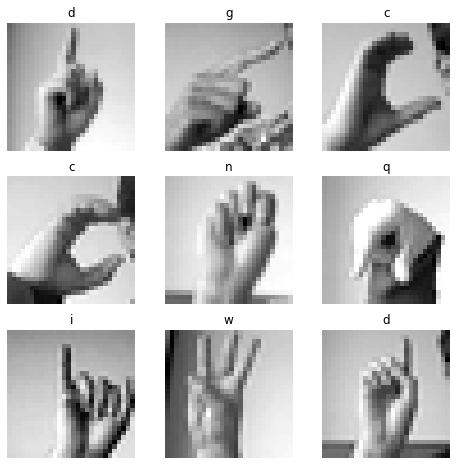

In [286]:
# Plotting some of data.
plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(Alphabet_labels[Y_tarin[i]])
    plt.axis('off')

> Resizing images to be 32 x 32 x 3 as the minimum values for MobileNet2

In [287]:
temp_train = []
temp_val   = []

for i in range(len(X_train)):
    temp_train.append(cv2.resize(X_train[i], (32, 32)))

for i in range(len(X_val)):
    temp_val.append(cv2.resize(X_val[i], (32, 32)))
    
X_train = np.array(temp_train)
X_val   = np.array(temp_val)

> combining channels to make 3 channels instead of 1

In [288]:
temp_train2 = []
temp_val2   = []

for i in range(len(X_train)):
    gray = X_train[i]
    resized_img = cv2.merge((gray, gray, gray))
    temp_train2.append(resized_img)
    
for i in range(len(X_val)):
    gray = X_val[i]
    resized_img = cv2.merge((gray, gray, gray))
    temp_val2.append(resized_img)
    
X_train = np.array(temp_train2)
X_val   = np.array(temp_val2)

print(f'New shape is: {X_train[0].shape}')

New shape is: (32, 32, 3)


<a id='CNN'></a>
## CNN Model

In [289]:
process_input =  tf.keras.applications.mobilenet_v2.preprocess_input

> Making Callbacks, first with the checkpoints for best validation_set model.

In [290]:
checkpoint_path = "checkpoints/"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 mode='max',
                                                 verbose=1)

> Learning Rate decay

In [291]:
def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * 0.99

    
lr_Scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

In [292]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [293]:
def model(input_size = (32, 32)):
    imgSize = input_size + (3, )
    
    base_model = tf.keras.applications.MobileNetV2(
        input_shape = imgSize,
        include_top = False,
        weights     = 'imagenet')
    
    base_model.trainable = False
    
    
    inputs = tfl.Input(shape = imgSize)
    x      = process_input(inputs)
    
    x      = base_model(inputs, training = False)
    x      = tfl.GlobalAveragePooling2D()(x)
    
    x      = tfl.Dense(125, activation = 'relu')(x)
    x      = tfl.Dropout(0.4)(x) 
    
    Outputs      = tfl.Dense(26, activation="softmax")(x)
    
    modle = tf.keras.Model(inputs, Outputs)

    return modle

In [300]:
Model = model()

In [301]:
# Unfreezing some layers
base_model = Model.layers[1]
base_model.trainable = True

freezing = len(base_model.layers) - 3
for layer in base_model.layers[:freezing]:
    layer.trainable = False

In [302]:
Model.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1, 1, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_27  (None, 1280)              0         
_________________________________________________________________
dense_59 (Dense)             (None, 125)               160125    
_________________________________________________________________
dropout_29 (Dropout)         (None, 125)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 26)                3276      
Total params: 2,421,385
Trainable params: 575,561
Non-trainable params: 1,845,824
__________________________________________

In [303]:
Model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

In [304]:
history = Model.fit(X_train, Y_tarin, validation_data=(X_val, Y_val), epochs=15, batch_size = 128, verbose=1, callbacks=[cp_callback, early_stop, lr_Scheduler])

Epoch 1/15

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
215/215 [==============================] - 7s 19ms/step - loss: 1.5704 - accuracy: 0.5093 - val_loss: 0.8832 - val_accuracy: 0.6873

Epoch 00001: val_accuracy improved from 0.03444 to 0.68726, saving model to checkpoints/
Epoch 2/15

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
215/215 [==============================] - 3s 15ms/step - loss: 0.5759 - accuracy: 0.8062 - val_loss: 0.5762 - val_accuracy: 0.7840

Epoch 00002: val_accuracy improved from 0.68726 to 0.78402, saving model to checkpoints/
Epoch 3/15

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009900000470224768.
215/215 [==============================] - 3s 15ms/step - loss: 0.3439 - accuracy: 0.8888 - val_loss: 0.4836 - val_accuracy: 0.8300

Epoch 00003: val_accuracy improved from 0.78402 to 0.83003, saving model to checkpoints/
Epoch 4/15

Epoch 00004: LearningRateScheduler se

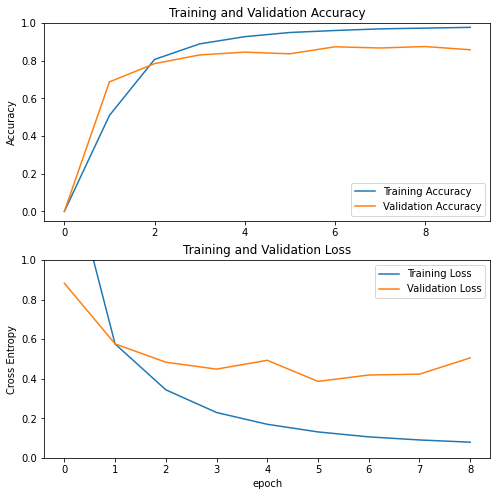

In [305]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
Model.save('SwhiMee2.h5')

In [ ]:
results = Model.predict(X_train)

In [ ]:
i = 2
print(f'Predicted_value: {Alphabet_labels[np.argmax(results[i])]}\nThe actual value: {Alphabet_labels[Y_tarin[i]]}')

<a id='conclusions'></a>
## Conclusions